[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/liapla/Game-Theory-and-Epidemics/blob/main/Modification.ipynb)

# **In this notebook we will use the Germany's covid-19 data to investigate the self-interest policy for vaccination among different age groups.**

# **First we define a payoff function for vaccinated and unvaccinated people and then calculate the values for these two functions in a time period (01.01.2021 till 01.07.2021).**
# **We call the x of the intersection point of the payoff functions the "critical age". For this age, the probabilty of dying from the vaccination is equal to the probability of dying due to Covid-19  during period of time.**
#**We find the critical age for diffent time periods of planning.**
#**We also investigate the impact of the course of the pandemic in 2021 on the critical age.**


#Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib as mpl
import scipy.optimize as opt
import csv
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from scipy import signal

mpl.rcParams["font.sans-serif"] = "Arial"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.labelcolor"] = "black"
mpl.rcParams["axes.edgecolor"] = "black"
mpl.rcParams["xtick.color"] = "black"
mpl.rcParams["ytick.color"] = "black"
mpl.rcParams["xtick.labelsize"] = 6.5
mpl.rcParams["ytick.labelsize"] = 6.5
mpl.rcParams["axes.labelsize"] = 8
mpl.rcParams["axes.titlesize"] = 8
mpl.rcParams["figure.titlesize"] = 6.5
mpl.rcParams["legend.fontsize"] = 5
mpl.rcParams['figure.dpi'] =300


#Importing "COVID-19 Tracking Germany" data from [Kaggle](https://www.kaggle.com/datasets/headsortails/covid19-tracking-germany?resource=download&select=covid_de.csv)

In [2]:
data = pd.read_csv('https://github.com/liapla/Game-Theory-and-Epidemics/blob/a3c05b32b0644e5de2b4001364ca3d2faac14b04/covid_de.csv?raw=true') #does not work for execution with colab execution button at the top, instead use: data=pd.read_csv('url')
df = data.filter(['age_group' ,'date' ,'cases',	'deaths','recovered'])
df = df.dropna()
group_age_list = np.array(df.age_group.unique())
group_age_list = [['00-04'] ,['05-14'] ,['15-34'], ['35-59'], ['60-79' ,'80-99']]
population = np.array([0.79+3 ,1+6.06+1,2.01+2.4+3.7+10.52,5.26+23.07,5.99+18.44])*10**6
age_values = [2,int((5+14)/2),int((15+34)/2),int((35+59)/2),int((60+99)/2)]
df.head()

,age_group,date,cases,deaths,recovered
0,00-04,2020-03-27,1,0,1
1,00-04,2020-03-28,1,0,1
2,00-04,2020-04-03,1,0,1
3,00-04,2020-10-18,1,0,1
4,00-04,2020-10-22,1,0,1


#Importing the data for the age based covid IFR from the [Sorenson et al.](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(21)02867-1/fulltext#seccestitle140)

[]

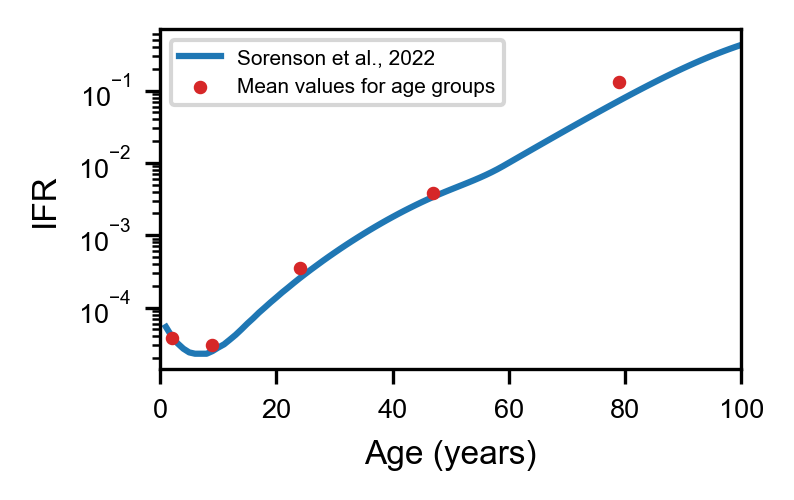

In [9]:
dataIFR = pd.read_csv('https://github.com/liapla/Game-Theory-and-Epidemics/blob/a3c05b32b0644e5de2b4001364ca3d2faac14b04/ifr_age.txt?raw=true',names = ['age','ifr','idk'])
age_series, dcov_values = np.array(dataIFR.age), np.array(dataIFR.ifr)/100

average_d_cov = [np.mean(dcov_values[0:4]) ,np.mean(dcov_values[4:14]),np.mean(dcov_values[14:34]),np.mean(dcov_values[34:59]),np.mean(dcov_values[59:])]

fig ,ax = plt.subplots(1,1,figsize = (2.5,1.5))
ax.plot(age_series,dcov_values,label='Sorenson et al., 2022') 
ax.scatter(age_values, average_d_cov,color='tab:red',label = 'Mean values for age groups',s =5, zorder=10)
ax.set_yscale("log")
ax.set_xlim(0,100)
ax.set_xlabel('Age (years)')
ax.set_ylabel('IFR')
ax.legend()
plt.plot()

#Definig the payoff for the unvaccinated : $E_{nonvac} = IFR(age) (I(t_2)-I(t_1))/N(age)$, where the IFR describes the age dependent risk of dying from Covid19 and I is the cumulative number of Infected at a given time t and N(age) is the population size in that age group.

In [10]:
def E_non_vac(age_ind, T1 , T2 ):
  if age_ind != 4:
      age = group_age_list[age_ind][0]
      df_age = df[df['age_group'] == age]

  else:                                                                         ### We are combining the age groups above 60 because of the population data limits
      age1 = group_age_list[age_ind][0]
      age2 = group_age_list[age_ind][1]
      df_age1 = df[df['age_group'] == age1]
      df_age2 = df[df['age_group'] == age2]
      df_age = pd.concat([df_age1 , df_age2])
  
  df_age = df_age.groupby(['date']).sum()
  Date = np.array(df_age.index)
  ind1 = np.where(Date == T1)[0][0]
  ind2 = np.where(Date == T2)[0][0]
  Death = np.array(df_age.deaths)[ind1:ind2]
  Infected = np.array(df_age.cases)[ind1:ind2]
  Death_comul = np.cumsum(Death)
  Infected_comul = np.cumsum(Infected)

  return -average_d_cov[age_ind]* (Infected_comul[-1] - Infected_comul[0])/population[age_ind]



#Comparing the $E_{vac}$ and $E_{nonvac}$ for a time period of (01.01.2021,01.07.2021)

In [11]:
E_non_list = []
E_vac = -10**(-6)
test_t1 = '2021-01-01'
test_t2 = '2021-07-01'
for j in range(len(group_age_list)):
  E_non_list.append(E_non_vac(j , test_t1 ,test_t2 ))

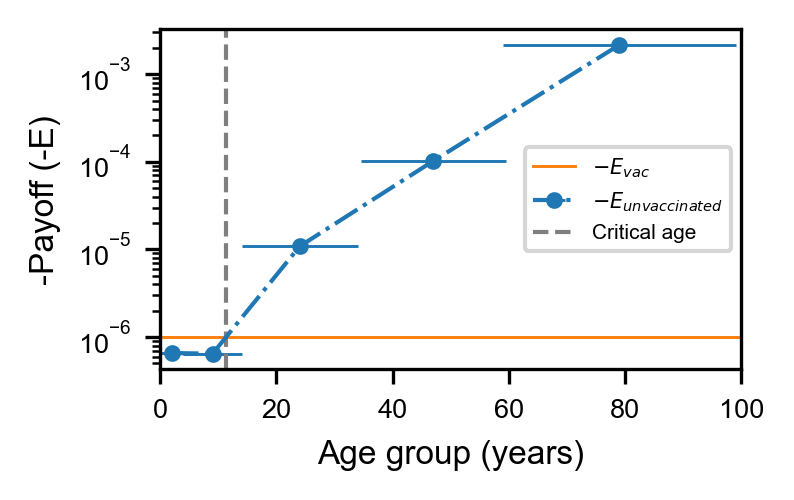

In [12]:
age_error = [2,5,10,12.5,20]
fig,ax = plt.subplots(1,1,figsize=(2.5,1.5))
ax.errorbar(age_values,-1*np.array(E_non_list),xerr = age_error ,label='$-E_{unvaccinated}$',ls='-.',marker = '.',capsize = 0,elinewidth = 0.7,linewidth = 1,capthick =0.7)
ax.axhline(-1*E_vac,label='$-E_{vac}$',linewidth = 0.7,color = 'tab:orange')

intersection_Age = np.interp(np.log(-E_vac),np.log(-1*np.array(E_non_list)),np.array(age_values))
ax.axvline(intersection_Age,ls ='--',color='tab:gray',linewidth=1,label='Critical age')
ax.set_yscale('log')
ax.set_ylabel('-Payoff (-E)')
ax.set_xlabel('Age group (years)')
ax.set_xlim(0,100)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1,]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 

We call the age at the intersection point the "critical age". It means that at this age the payoff for getting vaccinated and not getting vaccinated is equal.

#Finding critical ages for a range of interval time values
Now we find the critical age for a range of time intervals $ΔT$, all starting from 01.01.2021.

In [ ]:
age_intersection = []
T2_list =[]
starttime = pd.to_datetime('2021-01-01')
str_start = '2021-01-01'
for week in range(1,52):
  T2_list.append(str(starttime + DateOffset(days= week * 7)).split(" ", 1)[0])

for endtime in T2_list:
    E_non_list = []
    for j in range(len(group_age_list)):
      E_non_list.append(E_non_vac(j , str_start ,endtime))       ###compute payoff E_non_vac for [T1,T2]

    age_intersection.append(np.interp(np.log(-E_vac),np.log(-1*np.array(E_non_list)),np.array(age_values)))   ###find intersection between E_vac and E_non_vac

[]

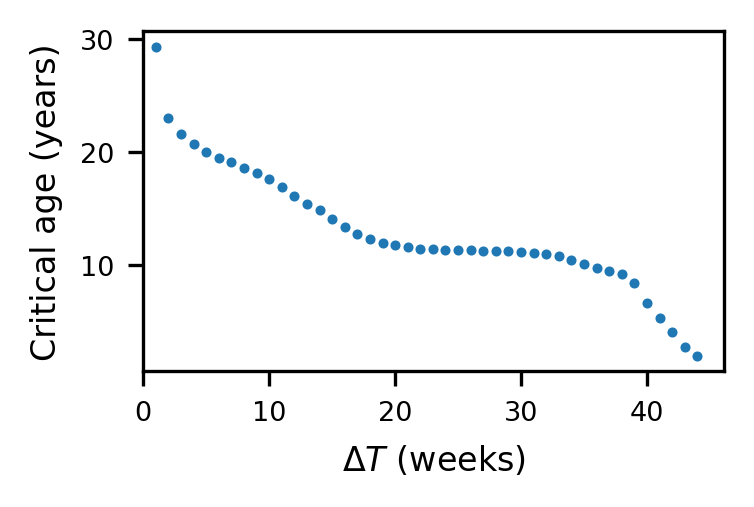

In [ ]:
fig , ax = plt.subplots(1,1,figsize=(2.5,1.5))
ax.scatter(range(1,52)[:len(age_intersection[:-7])], age_intersection[:-7],s = 2)
ax.set_ylabel('Critical age (years)')
ax.set_xlabel('$\Delta T$ (weeks)')
ax.set_xlim(0)

plt.plot()

#Finding the critical age for a constant $\Delta T = 1 $ month but different starting points

In [ ]:
dT = 1
age_intersection = []
T1_list =['2021-01-01']
T2_list = []
T2_list.append(str(pd.to_datetime(T1_list[-1]) + DateOffset(months= dT)).split(" ", 1)[0])
T_center = []
T_center.append(str(pd.to_datetime(T1_list[-1]) +DateOffset(days= int(dT/2)) ).split(" ", 1)[0])


for interval in range(12):
  T1_list.append(str(pd.to_datetime(T1_list[-1]) + DateOffset(months= 1)).split(" ", 1)[0])
  T2_list.append(str(pd.to_datetime(T1_list[-1]) + DateOffset(months= dT)).split(" ", 1)[0])
  T_center.append(str(pd.to_datetime(T1_list[-1]) +DateOffset(months= int(dT/2)) ).split(" ", 1)[0])



for ind_t in range(12):
    E_non_list = []
    for j in range(len(group_age_list)):
      E_non_list.append(E_non_vac(j , T1_list[ind_t] ,T2_list[ind_t]))       ###compute payoff E_non_vac for [T1,T2]

    age_intersection.append(np.interp(np.log(-E_vac),np.log(-1*np.array(E_non_list)),np.array(age_values)))   ###find intersection between E_vac and E_non_vac

In [ ]:
cases = df.groupby(['date']).sum().cases.loc['2021-02-01':'2022-01-01']
date_case = df.groupby(['date']).sum().loc['2021-02-01':'2022-01-01'].index
date_case = pd.to_datetime(date_case)

[]

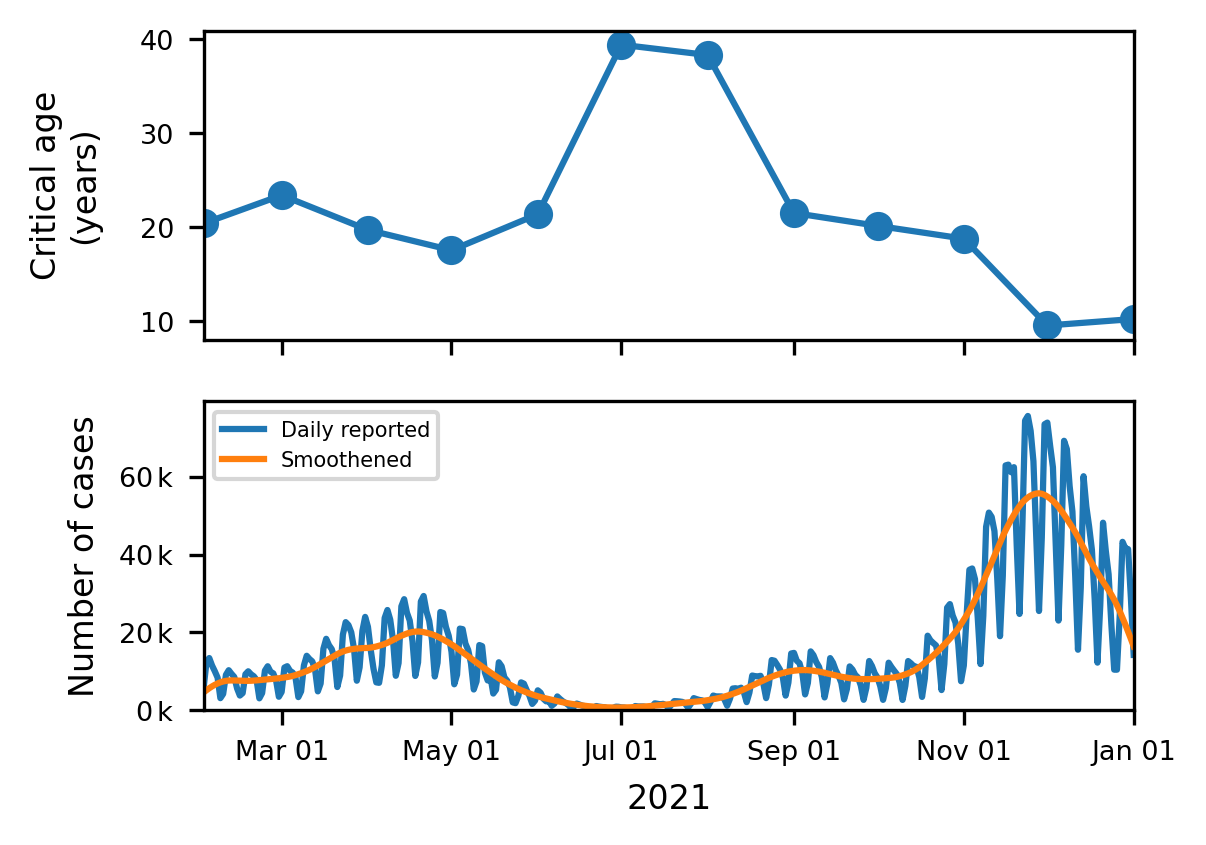

In [ ]:
fig , ax = plt.subplots(2,1,figsize=(4,3))
ax[0].plot(pd.to_datetime(T_center[1:]), age_intersection)
ax[0].scatter(pd.to_datetime(T_center[1:]), age_intersection)

ax[0].set_ylabel('Critical age\n(years)')
ax[0].set_xticklabels([],rotation = 'vertical')
ax[0].set_xlim(datetime(2021,2,1),datetime(2022,1,1))
ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval = 2))

window_hann = signal.windows.hann(30)
window_hann /= sum(window_hann)
newcases_filtered = signal.convolve(cases,window_hann,mode = 'same')

ax[1].plot(date_case,cases, label = 'Daily reported')
ax[1].plot(date_case,newcases_filtered, label = 'Smoothened')
ax[1].set_xlabel('2021')
ax[1].set_ylabel('Number of cases')
# plt.xticks(T_center[1:],rotation = 'vertical')
ax[1].set_xlim(datetime(2021,2,1),datetime(2022,1,1))
ax[1].set_ylim(0)
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,_: str(int(x/1000)) +'$\,$k'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
ax[1].legend()

fig.align_ylabels(ax)
plt.plot()

As we can see from the above plots, there is a negative correlation between the critical age and the number of the daily new cases. We can interpret it this way: When the number of the new cases is higher, the situation is more dangerous and it makes sanse for even young people to get vaccinated.